In [1]:
import pandas

cache_size_data = pandas.read_csv("cifar-data/cache-size-results.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})
min_queue_size_data = pandas.read_csv("cifar-data/min-queue-size.csv", converters={"Miss Rate": lambda percentage: float(percentage.rstrip('%'))/100})

In [2]:
import collections

BATCH_SIZE = 512
COLORS = [
    ['plum', 'hotpink', 'crimson', 'firebrick'],
    ['plum', 'hotpink', 'crimson', 'firebrick'],
]

def get_bucketed_data(data, bucket_fields, *fields):
    res = []
    for epoch in data['Epoch'].drop_duplicates():    
        epoch_data = data.loc[(data['Epoch'] == epoch) & (data['Batch Size'] == BATCH_SIZE)][[*bucket_fields, *fields]]
        res.append(epoch_data)
    return res

In [3]:
min_queue_grouped_data = get_bucketed_data(min_queue_size_data, ["Cache Size", "Minimum Queue Size"], "Data Loading Time (s)", "Miss Rate")
cache_grouped_data = get_bucketed_data(cache_size_data, ["Cache Size"], "Data Loading Time (s)", "Miss Rate")
min_queue_grouped_data = [df.reset_index() for df in min_queue_grouped_data]
cache_grouped_data = [df.reset_index() for df in cache_grouped_data]

cache_sizes = min_queue_grouped_data[0].reset_index()["Cache Size"].drop_duplicates()
for i, epoch_data in enumerate(cache_grouped_data):
    cache_size_res = pandas.concat([
        epoch_data.loc[epoch_data["Cache Size"] == cache_size]
        for cache_size in cache_sizes
    ])
    cache_size_res["Minimum Queue Size"] = 0
    min_queue_grouped_data[i] = min_queue_grouped_data[i].append(cache_size_res)
    
min_queue_grouped_data = [df.set_index("Cache Size").sort_index() for df in min_queue_grouped_data]

In [4]:
ratios = set()
for epoch_data in min_queue_grouped_data:
    epoch_data["Minimum Queue Ratio"] = epoch_data["Minimum Queue Size"]/epoch_data.index
    ratios.update(epoch_data["Minimum Queue Ratio"])

In [5]:
from matplotlib import pyplot as plt
import numpy
import inflect

plt.rcParams.update({'font.size': 14})

BAR_WIDTH = 0.2
def make_queue_ratio_plots(dependent_var):
    inflect_engine = inflect.engine()
    for i, epoch_data in enumerate(min_queue_grouped_data):
        plt.figure(figsize=(10,4))
        epoch_name = inflect_engine.number_to_words(inflect_engine.ordinal(i + 1)) + " Epoch"
        epoch_name = epoch_name[0].upper() + epoch_name[1:]
        for j, ratio in enumerate(sorted(ratios)):
            plt.ylabel(dependent_var)
            plt.xlabel("Cache Size")
            plt.title(f"CIFAR-10 {dependent_var} vs Cache Size ({epoch_name})")
            
            runs_with_ratio = epoch_data.loc[epoch_data["Minimum Queue Ratio"] == ratio]
            cache_size_items = collections.defaultdict(list)
            for cache_size, row in runs_with_ratio.iterrows():
                cache_size_items[cache_size].append(row[dependent_var])
            averages = {
                cache_size: sum(data)/len(data)
                for cache_size, data in cache_size_items.items()
            }
            errors = {
                cache_size: numpy.std(data)
                for cache_size, data in cache_size_items.items()       
            }
            
            x, y = zip(*sorted(averages.items(), key=lambda item: item[0]))
            yerrs = [errors[cache_size] for cache_size in x]
            x_ticks = numpy.arange(len(x))
            bar_shift = BAR_WIDTH * j - BAR_WIDTH * (len(ratios) - 1)/2
            plt.bar(
                numpy.array(x_ticks) + bar_shift,
                list(y),
                BAR_WIDTH,
                yerr=yerrs,
                label=f"{int(ratio * 100)}%",
                capsize=4,
                hatch='...',
                edgecolor='white',
                color=COLORS[i][j]
            )
            plt.xticks(x_ticks, x)
            plt.legend(title="  Pre-Fetch Threshold\n(As Ratio of Cache Size)", ncol=2)
        plt.grid(axis='y', alpha=0.5)
        # plt.savefig(f"RESNET MQS {dependent_var} vs Cache Size ({epoch_name})", dpi=800)
        # plt.savefig(f"RESNET MQS {dependent_var} vs Cache Size ({epoch_name})", bbox_inches="tight", dpi=300)


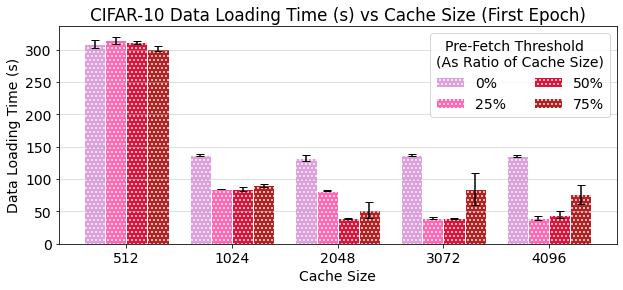

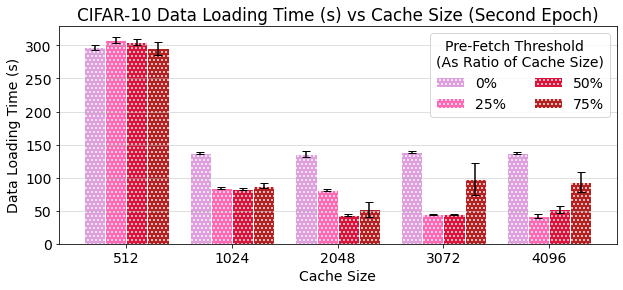

In [6]:
make_queue_ratio_plots("Data Loading Time (s)")

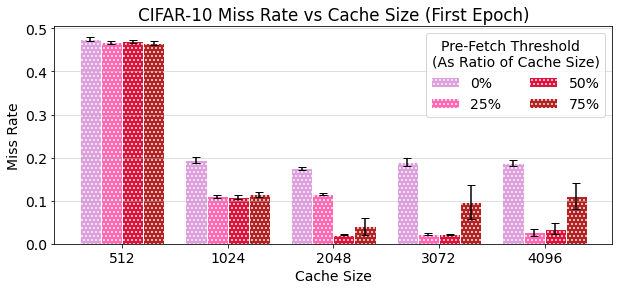

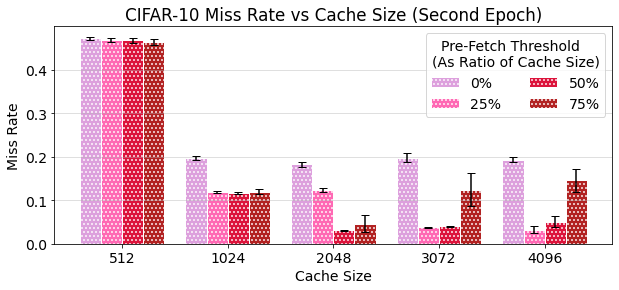

In [7]:
make_queue_ratio_plots("Miss Rate")